In [1]:
# pip install gym
import gym

import numpy as np
import random
import os
import collections

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.animation as animation

mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

mpl.rc('animation', html='jshtml')

from array2gif import write_gif

### OpenAI Gym. Маятник на тележке - Cartpole

![cartpole](https://www.gymlibrary.dev/_images/cart_pole.gif)

<font size="3">
<p>Эта среда - одна из систем в <a href='https://www.gymlibrary.dev/environments/classic_control/index.html'>Classic Control environments</a>.</p>
<div class="table-wrapper colwidths-auto docutils container">
<table class="docutils align-default">
<thead>
<tr class="row-odd"><th class="head"><p></p></th>
<th class="head"><p></p></th>
</tr>
</thead>
<tbody>
<tr class="row-even"><td><p>Пространство действий</p></td>
<td><p>Discrete(2)</p></td>
</tr>
<tr class="row-odd"><td><p>Размер вектора состояния</p></td>
<td><p>(4,)</p></td>
</tr>
<tr class="row-even"><td><p>Верхние границы</p></td>
<td><p>[4.8   inf 0.42  inf]</p></td>
</tr>
<tr class="row-odd"><td><p>Нижние границы</p></td>
<td><p>[-4.8   -inf -0.42  -inf]</p></td>
</tr>
<tr class="row-even"><td><p>Импорт</p></td>
<td><p><code class="docutils literal notranslate"><span class="pre">gym.make(&quot;CartPole-v1&quot;)</span></code></p></td>
</tr>
</tbody>
</table>
</font>

In [2]:
env = gym.make('CartPole-v1')

### Состояния

<table class="docutils align-default">
<thead>
<tr class="row-odd"><th class="head"><p>№</p></th>
<th class="head"><p>Переменная</p></th>
<th class="head"><p>Min</p></th>
<th class="head"><p>Max</p></th>
</tr>
</thead>
<tbody>
<tr class="row-even"><td><p>0</p></td>
<td><p>Положение тележки</p></td>
<td><p>-4.8</p></td>
<td><p>4.8</p></td>
</tr>
<tr class="row-odd"><td><p>1</p></td>
<td><p>Скорость тележки</p></td>
<td><p>-Inf</p></td>
<td><p>Inf</p></td>
</tr>
<tr class="row-even"><td><p>2</p></td>
<td><p>Угол маятника с вертикалью</p></td>
<td><p>~ -0.418 rad (-24°)</p></td>
<td><p>~ 0.418 rad (24°)</p></td>
</tr>
<tr class="row-odd"><td><p>3</p></td>
<td><p>Угловая скорость маятника</p></td>
<td><p>-Inf</p></td>
<td><p>Inf</p></td>
</tr>
</tbody>
</table>

In [3]:
env.observation_space.shape[0]

4

In [4]:
obs = env.reset()
obs

array([-0.0227256 , -0.02211267,  0.03903146,  0.04759679], dtype=float32)

In [5]:
Obs = collections.namedtuple("CartPole_obs", "x v theta omega")
Obs(*obs)

CartPole_obs(x=-0.0227256, v=-0.022112668, theta=0.039031465, omega=0.047596786)

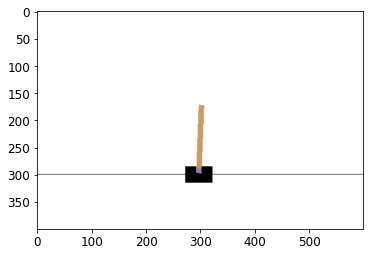

In [6]:
img = env.render(mode="rgb_array")
plt.imshow(img)

### Начальные условия

Все переменные векора состояний инициализируются случайными величинами равномерно распределёнными в интервале (-0.05, 0.05)


### Начало эпизода

In [7]:
obs = env.reset()
obs0 = Obs(*obs)
print(obs0)

CartPole_obs(x=-0.025261775, v=-0.026911506, theta=0.022970565, omega=0.042557433)


### Действия

<table class="docutils align-default">
<thead>
<tr class="row-odd"><th class="head"><p>№</p></th>
<th class="head"><p>Действие</p></th>
</tr>
</thead>
<tbody>
<tr class="row-even"><td><p>0</p></td>
<td><p>Двинуть тележку налево</p></td>
</tr>
<tr class="row-odd"><td><p>1</p></td>
<td><p>Двинуть тележку направо</p></td>
</tr>
</tbody>
</table>

In [8]:
env.action_space

Discrete(2)

### Действие  $a = 1$

In [9]:
obs, reward, done, info = env.step(1)
obs1 = Obs(*obs)
print(obs1)

CartPole_obs(x=-0.025800006, v=0.16787365, theta=0.023821713, omega=-0.24279048)


In [10]:
print(obs1.v > obs0.v, obs1.omega < obs0.omega)

True True


### Действие $a = 0$

In [11]:
obs, reward, done, info = env.step(0)
obs2 = Obs(*obs)
print(obs2)

CartPole_obs(x=-0.022442533, v=-0.027580326, theta=0.018965904, omega=0.05731023)


In [12]:
print(obs2.v < obs1.v, obs2.omega > obs1.omega)

True True


### Терминальные условия

Эпизод заканчивается привыполнении одного из следующих условий:

- Termination: Маятник отклонен от вертикали больше чем на ±12°

- Termination: Положение тележки ±2.4 (центр тележки выходит за границы рисунка)

- Truncation: Эпизод продолжается 500 шагов (200 для версии v0)

### Вознаграждение

Поскольку цель задачи - балансировать маятник около верхнего состояния, вознаграждение +1 назначается за каждый шаг, пока система не достигла терминального состояния.

In [13]:
def plot_environment(env, figsize=(5,4)):
    plt.figure(figsize=figsize)
    img = env.render(mode="rgb_array")
    plt.imshow(img)
    plt.axis("off")
    return img

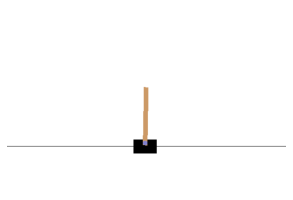

In [14]:
img = plot_environment(env)
plt.show()

### Пример класса для работы с Cartpole

In [15]:
class CartPolePlayer:
    
    def record_scenario(self, env, policy, num_frames=100) -> dict:
        frames = []
        obs_mat = np.empty((num_frames, 4))
        actions = np.empty((num_frames,))
        rewards = np.empty((num_frames,))
        dones = np.empty((num_frames,), dtype=int)
        first_done_info = ''
        obs = env.reset()  # initial observation
    
        for i in range(num_frames):
            action = policy(obs)
            obs, reward, done, info = env.step(action)
            img = env.render(mode="rgb_array")
            frames.append(img)
            obs_mat[i,:] = obs
            actions[i] = action
            rewards[i] = reward
            dones[i] = int(done)
        
            if done and first_done_info == '':
                first_done_info = info

        record = {'frames': frames, 'obs': obs_mat, 'actions': actions, 'rewards': 
              rewards, 'dones': dones, 'first_done_info':first_done_info}
        
        return record

    
    def update_scene(self, num, frames, patch, time_text, obs_mat, actions, cum_rewards, dones):
        patch.set_data(frames[num])
        text = f"frame: {num}"
        text += ", Obs: ({:.3f}, {:.3f}, {:.3f}, {:.3f})\n".format(*obs_mat[num,:])
        text += f"Action: {actions[num]}"
        text += f", Cumulative Reward: {cum_rewards[num]}"
        text += f", Done: {dones[num]}"
        time_text.set_text(text)
        
        return patch, time_text
    
    
    def plot_animation(self, record, repeat=False, interval=40):
        '''record should contain
        frames: list of N frames
        obs: (N, 4) array of observations
        actions: (N, ) array of actions {0, 1}
        rewards: (N, ) array of rewards at each step {0, 1}
        dones: (N, 1) array of dones {0, 1}
        '''
        cum_rewards = np.cumsum(record['rewards'])
        frames = record['frames']
        fig = plt.figure()
        patch = plt.imshow(record['frames'][0])
        ax = plt.gca()
        time_text = ax.text(0., 0.95,'',horizontalalignment='left',verticalalignment='top', transform=ax.transAxes)
        plt.axis('off')
        anim = animation.FuncAnimation(
            fig, self.update_scene, fargs=(frames, patch, time_text, record['obs'], record['actions'], cum_rewards, record['dones']),
            frames=len(frames), repeat=repeat, interval=interval)
        plt.close()
        
        return anim   
    
    
    def test_policy(self, policy_func, n_scenario = 1000, max_actions = 500, verbose=False):
        final_rewards = []
        for episode in range(n_scenario):
            if verbose and episode % 50 == 0:
                print(episode)
            episode_rewards = 0
            obs = env.reset()  # reset to a random position
            for step in range(max_actions):
                action = policy_func(obs)
                obs, reward, done, info = env.step(action)
                episode_rewards += reward
                if done:
                    break
            final_rewards.append(episode_rewards)
    
        return final_rewards

    
    def plot_policy(self, final_rewards, policy_name:str=''):
        fig = plt.plot(range(len(final_rewards)), final_rewards)
        plt.grid()
        plt.title(policy_name + " Mean Reward {:.2f}, Std Reward {:.2f}".format(np.mean(final_rewards), np.min(final_rewards)))
        plt.ylabel('Cum Reward')
        plt.xlabel('Iteration')
        plt.ylim(0, max(final_rewards) * 1.1)
        
        return fig
    
    
    def save_gif(self, recorded_episode):
        recorded_episode['frames'][1].shape
        write_gif([np.transpose(f, axes=[2,0, 1]) for f in recorded_episode['frames']], 'recorded_episode.gif', fps=30)

In [16]:
player = CartPolePlayer()

### Стратегия случайных действий

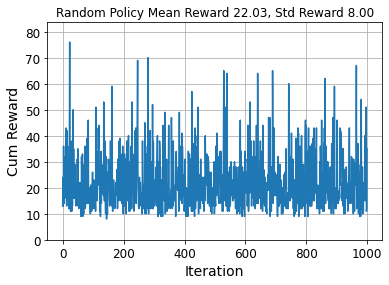

In [17]:
def rand_policy(obs):
    return random.randint(0, 1)

env.seed(42)
random.seed(0)

rand_rewards = player.test_policy(rand_policy)
pt = player.plot_policy(rand_rewards, "Random Policy")

### Наивная стратегия (управление по отклонению маятника)

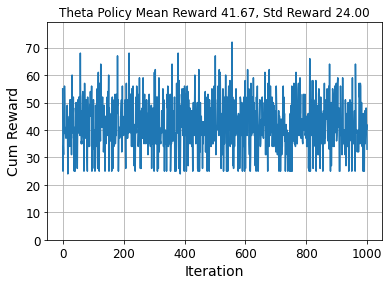

In [18]:
def theta_policy(obs):
    angle = obs[2]
    return 0 if angle < 0 else 1

env.seed(42)
random.seed(0)

theta_rewards = player.test_policy(theta_policy)
pt = player.plot_policy(theta_rewards, "Theta Policy")

### Наивная стратегия (управление по угловой скорости)

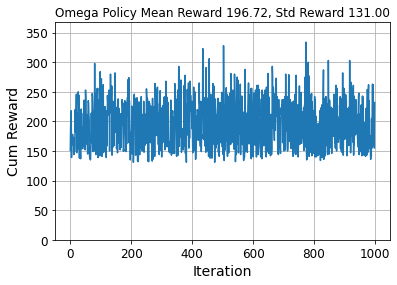

In [19]:
def omega_policy(obs):
    w = obs[3]
    return 1 if w > 0 else 0

env.seed(42)
random.seed(0)

omega_rewards = player.test_policy(omega_policy)
pt = player.plot_policy(omega_rewards, "Omega Policy")

### Комбинация двух наивных стратегий, внезапно приводящая к успеху

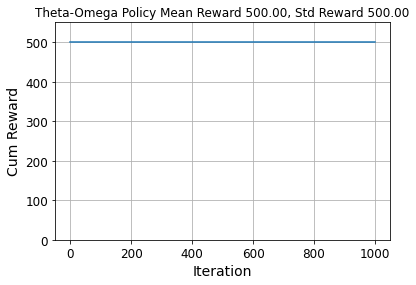

In [20]:
def theta_omega_policy(obs):
    theta, w = obs[2:4]
    if abs(theta) < 0.03:
        return 0 if w < 0 else 1
    else:
        return 0 if theta < 0 else 1
    
env.seed(42)
random.seed(0)

# the cart-pole experiment will end if it lasts more than 500 steps, with info="'TimeLimit.truncated': True"
theta_omega_rewards = player.test_policy(theta_omega_policy, max_actions=510) 
player.plot_policy(theta_omega_rewards, "Theta-Omega Policy")

### Запись эпизода

In [21]:
theta_record = player.record_scenario(env, theta_omega_policy, 100)

### Анимация

In [22]:
player.plot_animation(theta_record)

### Сохранение gif

In [ ]:
player.save_gif(theta_record)

# строка для маркдаун - <img src="recorded_episode.gif" width="750" align="center">